In [3]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import linear_model, neighbors, ensemble, svm
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

from imblearn.over_sampling import SMOTE

#to scale certain columns
class CustomScaler(BaseEstimator,TransformerMixin): 
    def __init__(self,columns,copy=True,with_mean=True,with_std=True):
        self.scaler = StandardScaler(copy,with_mean,with_std)
        self.columns = columns

    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns], y)
        return self

    def transform(self, X, y=None, copy=None):
        init_col_order = X.columns
        X_scaled = pd.DataFrame(self.scaler.transform(X[self.columns]), columns=self.columns)
        X_not_scaled = X.ix[:,~X.columns.isin(self.columns)]
        return pd.concat([X_not_scaled, X_scaled], axis=1)[init_col_order]
# to calculate gini index (from kaggle)    
def Gini(y_true, y_pred):
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]
    
    # sort rows on prediction column 
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:,0].argsort()][::-1,0]
    pred_order = arr[arr[:,1].argsort()][::-1,0]
    
    # get Lorenz curves
    L_true = np.cumsum(true_order) / np.sum(true_order)
    L_pred = np.cumsum(pred_order) / np.sum(pred_order)
    L_ones = np.linspace(1/n_samples, 1, n_samples)
    
    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)
    
    # normalize to true Gini coefficient
    return G_pred/G_true



import plotly
plotly.tools.set_credentials_file(username='getanaccount', api_key='forfree')
import plotly.plotly as py
import plotly.graph_objs as go
import colorlover as cl

from IPython.display import Image
from IPython.display import HTML

import warnings

warnings.filterwarnings(
    module='scipy',
    action='ignore',
    message='Using a')

warnings.filterwarnings(
    module='sklearn',
    action='ignore',
    message='Data with')
warnings.filterwarnings("ignore",category=DeprecationWarning)   


colors = cl.to_rgb(cl.scales['10']['div']['BrBG'])
HTML(cl.to_html( cl.scales['10']['div']['BrBG'] ))

/root/.pyenv/versions/3.6.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/root/.pyenv/versions/3.6.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Importing the data

In [4]:
#import the data, manage nulls and date field
df = pd.read_csv('lemon_train.csv')

In [5]:
df.head()

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,...,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
1,2,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,...,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
2,3,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,...,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
3,4,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,...,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
4,5,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,...,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020


In [6]:
df.describe()

,RefId,IsBadBuy,VehYear,VehicleAge,WheelTypeID,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,BYRNO,VNZIP1,VehBCost,IsOnlineSale,WarrantyCost
count,72983.000000,72983.000000,72983.000000,72983.000000,69814.000000,72983.000000,72965.000000,72965.000000,72965.000000,72965.000000,72668.000000,72668.000000,72668.000000,72668.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000
mean,36511.428497,0.122988,2005.343052,4.176644,1.494299,71499.995917,6128.909217,7373.636031,8497.034332,9850.928240,6132.081287,7390.681827,8775.723331,10145.385314,26345.842155,58043.059945,6730.934326,0.025280,1276.580985
std,21077.241302,0.328425,1.731252,1.712210,0.521290,14578.913128,2461.992768,2722.491986,3156.285284,3385.789541,2434.567723,2686.248852,3090.702941,3310.254351,25717.351219,26151.640415,1767.846435,0.156975,598.846788
min,1.000000,0.000000,2001.000000,0.000000,0.000000,4825.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,835.000000,2764.000000,1.000000,0.000000,462.000000
25%,18257.500000,0.000000,2004.000000,3.000000,1.000000,61837.000000,4273.000000,5406.000000,6280.000000,7493.000000,4275.000000,5414.000000,6536.000000,7784.000000,17212.000000,32124.000000,5435.000000,0.000000,837.000000
50%,36514.000000,0.000000,2005.000000,4.000000,1.000000,73361.000000,6097.000000,7303.000000,8444.000000,9789.000000,6062.000000,7313.000000,8729.000000,10103.000000,19662.000000,73108.000000,6700.000000,0.000000,1155.000000
75%,54764.500000,0.000000,2007.000000,5.000000,2.000000,82436.000000,7765.000000,9021.000000,10651.000000,12088.000000,7736.000000,9013.000000,10911.000000,12309.000000,22808.000000,80022.000000,7900.000000,0.000000,1623.000000
max,73014.000000,1.000000,2010.000000,9.000000,3.000000,115717.000000,35722.000000,36859.000000,39080.000000,41482.000000,35722.000000,36859.000000,39080.000000,41062.000000,99761.000000,99224.000000,45469.000000,1.000000,7498.000000


In [7]:
df.PurchDate = pd.to_datetime(df.PurchDate)
df['pyear'] = df['PurchDate'].dt.year.astype(int)
df['pmonth'] = df['PurchDate'].dt.month.astype(int)
df['pday'] = df['PurchDate'].dt.day.astype(int)
#Drop the date and other columns
df.drop(['RefId', 'BYRNO', 'AUCGUART', 'PRIMEUNIT',
         'VNZIP1','WheelType','PurchDate'],1,inplace=True)

In [8]:
dnull = df.isnull().sum()
dnullsearch = dnull[dnull>500]
for i in dnullsearch.index:
    comp = df.loc[(df[i].isnull())&(df.IsBadBuy == 1)]
    print(i)
    print('Number of missing lemons: {}'.format(len(comp)))

Trim
Number of missing lemons: 374
WheelTypeID
Number of missing lemons: 2236


If we drop the nulls now, we would lose 2236 lemons, this could negatively impact the model

In [9]:
#Fill missing with most common type
df = df.fillna(df['WheelTypeID'].value_counts().index[0])

In [10]:
df.dropna(inplace=True)
#add 1 to vehicle age (for math)
df.VehicleAge = [x+1 for x in df.VehicleAge]

We split the date into their respective components.
 - Drop columns RefID and BYRNO as these are unique identifiers and could reduce the accuracy.
 - Drop AUGGUART and PRIMEUNIT for missing data (mostly null)
 - Drop VNZIP,WheelType,VehYear, PurchDate as there are other featers in the data to respresent them
 - Fill missing WheelType ID with most common in the set
 - Drop nulls
 - Add 1 year to vehicle age. mathematical convenienve.

In [11]:
print(df.shape)
df.head(3)

(72983, 30)


,IsBadBuy,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,...,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,VNST,VehBCost,IsOnlineSale,WarrantyCost,pyear,pmonth,pday
0,0,ADESA,2006,4,MAZDA,MAZDA3,i,4D SEDAN I,RED,AUTO,...,8552.0,11597.0,12409.0,FL,7100.0,0,1113,2009,12,7
1,0,ADESA,2004,6,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,AUTO,...,9222.0,11374.0,12791.0,FL,7600.0,0,1053,2009,12,7
2,0,ADESA,2005,5,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,AUTO,...,5557.0,7146.0,8702.0,FL,4900.0,0,1389,2009,12,7


## Feature Engineering

In [12]:
#Separate and combine columns of interest
models = df.Model
submods = df.SubModel
trims = df.Trim
chars = df[['Model','SubModel','Trim']] 
chars.head(3)

,Model,SubModel,Trim
0,MAZDA3,4D SEDAN I,i
1,1500 RAM PICKUP 2WD,QUAD CAB 4.7L SLT,ST
2,STRATUS V6,4D SEDAN SXT FFV,SXT


In [13]:
#create keyword list for model characteristics
mod_chars = ['2WD','V6','4C','PICKUP','6C','FWD',
             '4WD','AWD','SFI','EFI','DOHC','I4','MPI']

#create keyowrd list for submodel characteristics
submod_chars = ['SEDAN','4D','EXT','CAB','2D','CAB','WAGON',
                'REG','FFV','PASSENGER','SUV','SPORT',
                'UTILITY','QUAD','COUPE','MINIVAN','CUV']

#Create a dataframe and extract keywords from model and submodel.
sub_val_sets, mod_val_sets = pd.DataFrame(),pd.DataFrame()

for key in submod_chars:
    subs = np.where(submods.str.contains(key),1,0) #create array for dummied char prescence    
    sub_val_sets[key] = subs #insert to dataframe
for key in mod_chars:
    mods = np.where(models.str.contains(key),1,0)
    mod_val_sets[key] = mods

#combine the two characteristic sets
char_dummies = pd.concat([mod_val_sets,sub_val_sets],axis=1)  

#remove engine displacement size
displacement = chars.SubModel.str.split('.').reset_index()


#Only keep entries with engine size len(Submodel) == 2
disp_ok = []
modls = list(displacement.SubModel.dropna())
for i in modls:
    if len(i) == 2:
        disp_ok.append(i)
        
#Finally take the last element from 1st list, insert '.' add lasr element of 2nd list
displacements = []
for i in range(len(disp_ok)):
    beg = disp_ok[i][0][-1]
    end = disp_ok[i][1][0]
    whole = beg+'.'+end
    displacements.append(whole)
displacements = pd.Series(displacements)
ds_val_cnts = displacements.value_counts().reset_index()

#create dummie matrix for engine displacements
disp_keys = pd.DataFrame()
for key in ds_val_cnts['index']:
    dsps = np.where(df.SubModel.str.contains(key),1,0) #create array for dummied char prescence    
    disp_keys[key] = dsps #insert to dataframe
char_dummies.head(3)

,2WD,V6,4C,PICKUP,6C,FWD,4WD,AWD,SFI,EFI,...,REG,FFV,PASSENGER,SUV,SPORT,UTILITY,QUAD,COUPE,MINIVAN,CUV
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [14]:
disp_keys.head(3)

,3.5,4.2,3.3,4.7,3.0,3.9,2.2,4.6,4.0,2.7,...,5.6,2.8,2.0,5.9,6.0,2.9,3.6,5.2,8.1,6.2
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
#Isolate continuous attributes
plodf= df[['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice',
 'VehicleAge','VehOdo','WarrantyCost','IsBadBuy']].copy()
plodf.dropna(inplace=True)
#transform and reduce
plodf['crcp_cacp'] = plodf.MMRCurrentRetailCleanPrice - plodf.MMRCurrentAuctionCleanPrice
plodf['crcp_cacp_war'] = plodf['crcp_cacp']* df.WarrantyCost/df.VehicleAge
plodf['log_war_age'] = df.WarrantyCost/df.VehicleAge
plodf['odo_age'] = np.log(df.VehOdo/df.VehicleAge)
        
cont_df = plodf[['odo_age','log_war_age','crcp_cacp_war']]

In [16]:
#combine the four new feature dataframes
mod_val_sets.reset_index(drop=True,inplace=True)
sub_val_sets.reset_index(drop=True,inplace=True)
disp_keys.reset_index(drop=True,inplace=True)
cont_df.reset_index(drop=True,inplace=True)

add_feats = pd.concat([mod_val_sets,sub_val_sets,disp_keys,cont_df],axis=1)

#combine new features to our existing attributes
df.reset_index(drop=True,inplace=True)
model_df = pd.concat([df,add_feats],axis=1)

#general clean up
model_df.drop(['SubModel'],1,inplace=True)
model_df.Model = model_df.Model.str.split().str[0].str.strip()
model_df.Transmission = np.where(model_df.Transmission == 'AUTO',1,0)


In [17]:
model_df['avg_price'] = (model_df.MMRAcquisitionAuctionAveragePrice+model_df.MMRAcquisitionAuctionCleanPrice+\
                         model_df.MMRAcquisitionRetailAveragePrice+model_df.MMRAcquisitonRetailCleanPrice+\
                         model_df.MMRCurrentAuctionAveragePrice+model_df.MMRCurrentAuctionCleanPrice+\
                         model_df.MMRCurrentRetailAveragePrice+model_df.MMRCurrentRetailCleanPrice)/8
model_df['Exp_Margin'] = model_df.avg_price-model_df.VehBCost

In [18]:
price_pvals = pd.DataFrame()
prices = []
pvals = []
for col in plodf: 
    tstat = stats.ttest_ind(
    plodf[plodf.IsBadBuy == 1][col],
    plodf[plodf.IsBadBuy == 0][col])
    prices.append(col)
    pvals.append(tstat.pvalue)
price_pvals['price'] = prices
price_pvals['pvalues'] = pvals
price_pvals[price_pvals<.05]

,price,pvalues
0,MMRAcquisitionAuctionAveragePrice,7.843968e-192
1,MMRAcquisitionAuctionCleanPrice,2.320602e-170
2,MMRAcquisitionRetailAveragePrice,3.715172e-123
3,MMRAcquisitonRetailCleanPrice,7.354560e-113
4,MMRCurrentAuctionAveragePrice,6.457545e-184
5,MMRCurrentAuctionCleanPrice,4.367555e-166
6,MMRCurrentRetailAveragePrice,2.496764e-165
7,MMRCurrentRetailCleanPrice,7.960003e-153
8,VehicleAge,0.000000e+00
9,VehOdo,1.451802e-110


In [19]:
class1 = model_df[model_df.IsBadBuy == 1]
class0 = model_df[model_df.IsBadBuy == 0]

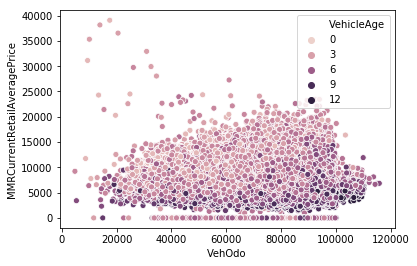

In [20]:
sns.scatterplot(x='VehOdo',y='MMRCurrentRetailAveragePrice',hue='VehicleAge',data=model_df, cmap='mako_r')

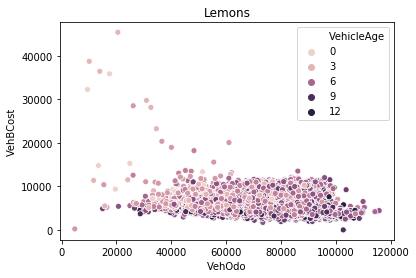

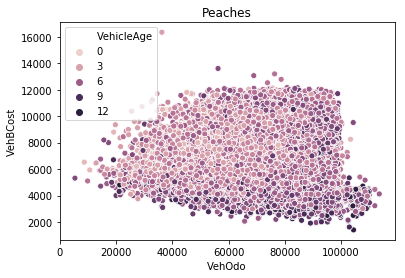

In [21]:
sns.scatterplot(x='VehOdo',y='VehBCost',hue='VehicleAge',data=class1, cmap='mako_r')
plt.title("Lemons")
plt.show()
sns.scatterplot(x='VehOdo',y='VehBCost',hue='VehicleAge',data=class0, cmap='mako_r')
plt.title('Peaches')
plt.show()

In [23]:
all_mods1 = model_df.groupby('Model')['VehicleAge','VehOdo','avg_price',
                                   'Exp_Margin','VehBCost','WarrantyCost'].mean().reset_index()
all_mods1['vic_cnt'] = model_df.Model.value_counts().reset_index().sort_values(by='index').reset_index()['Model']

diffs = list(set(model_df.Model.unique()).difference(class1.Model.unique()))
index_dict = dict((value, idx) for idx,value in enumerate(all_mods1.Model))
poss = [index_dict[x] for x in diffs]

all_mods1 = all_mods1.drop([233, 169, 179, 124, 70, 147, 244,
                            66, 113, 121, 126, 54, 218, 108, 
                            137, 166, 240, 159,104, 191, 105,
                            187, 139, 91, 19, 195, 153, 210, 
                            101, 207, 188, 127, 237, 182, 115,
                            197, 80]).reset_index().drop(['index'],1)
all_mods1['lem_cnt'] = class1.Model.value_counts().reset_index().sort_values(by='index').reset_index()['Model']
all_mods1['lem_pct'] = round(all_mods1.lem_cnt/all_mods1.vic_cnt,2)
all_mods1.head()

,Model,VehicleAge,VehOdo,avg_price,Exp_Margin,VehBCost,WarrantyCost,vic_cnt,lem_cnt,lem_pct
0,1500,5.952910,77272.132804,9648.591667,873.273148,8775.318519,1115.538624,1890,199,0.11
1,1500HD,7.333333,87215.111111,10775.027778,369.472222,10405.555556,1635.555556,9,1,0.11
2,2500,6.000000,81398.388889,9309.618056,-643.437500,9953.055556,1239.166667,18,2,0.11
3,2500HD,6.181818,84120.090909,7613.500000,-1181.954545,8795.454545,1351.454545,11,4,0.36
4,3.2,7.947368,81114.842105,7357.197368,-669.118421,8026.315789,1542.789474,19,6,0.32


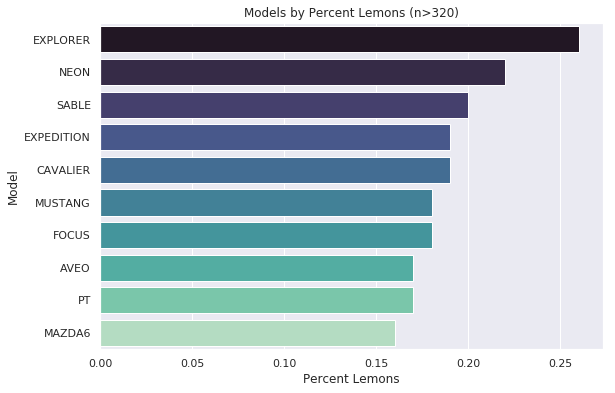

In [24]:
sns.set(palette='mako_r')
plt.figure(figsize=(9,6))

sns.barplot(y=all_mods1[all_mods1.vic_cnt > 321].sort_values(by='lem_pct',ascending=False)['Model'][:10],
            x=all_mods1[all_mods1.vic_cnt > 321].sort_values(by='lem_pct',ascending=False)['lem_pct'][:10],
            palette='mako')
plt.title('Models by Percent Lemons (n>320)')
plt.ylabel('Model')
plt.xlabel('Percent Lemons')
plt.savefig('lemonsbymodel.png')

In [25]:
margs = model_df.groupby(['Make','Model'])['Exp_Margin'].mean().groupby('Make').head().reset_index()
margs.Exp_Margin = [round(x,2) for x in margs.Exp_Margin]
margs.head()

,Make,Model,Exp_Margin
0,ACURA,3.2,-669.12
1,ACURA,MDX,315.02
2,ACURA,RSX,-649.31
3,ACURA,TL,1322.88
4,ACURA,TSX,2546.53


In [26]:
acc = list(margs[margs.Make == 'ACURA'].sort_values(by='Exp_Margin',ascending=False)['Exp_Margin'])
accmods = list(margs[margs.Make == 'ACURA'].sort_values(by='Exp_Margin',ascending=False)['Model'])

ch = list(margs[margs.Make == 'CHEVROLET'].sort_values(by='Exp_Margin',ascending=False)['Exp_Margin'])
chmods = list(margs[margs.Make == 'CHEVROLET'].sort_values(by='Exp_Margin',ascending=False)['Model'])

nis = list(margs[margs.Make == 'KIA'].sort_values(by='Exp_Margin',ascending=False)['Exp_Margin'])
nismods = list(margs[margs.Make == 'KIA'].sort_values(by='Exp_Margin',ascending=False)['Model'])

toy = list(margs[margs.Make == 'TOYOTA'].sort_values(by='Exp_Margin',ascending=False)['Exp_Margin'])
toymods = list(margs[margs.Make == 'TOYOTA'].sort_values(by='Exp_Margin',ascending=False)['Model'])

In [27]:
x = ['Acura', 'Chrysler','Kia','Toyota']
y = [acc[0],ch[0],nis[0],toy[0]]
y2 = [acc[1],ch[1],nis[1],toy[1]]
y3 = [acc[2],ch[2],nis[2],toy[2]]
y4 = [acc[3],ch[3],nis[3],toy[3]]
trace1 = go.Bar(
    x=x,
    y=y,
    text=[accmods[0],chmods[0],nismods[0],toymods[0]],
    textposition = 'auto',
    marker=dict(
        color=colors[8]
        ),
    opacity=0.9
)

trace2 = go.Bar(
    x=x,
    y=y2,
    text=[accmods[1],chmods[1],nismods[1],toymods[1]],
    textposition = 'auto',
    marker=dict(
        color=colors[6]),

        
    opacity=0.8
)
trace3 = go.Bar(
    x=x,
    y=y3,
    text=[accmods[2],chmods[2],nismods[2],toymods[2]],
    textposition = 'auto',
    marker=dict(
        color=colors[4],
        
        ),
    opacity=0.7
)
trace4 = go.Bar(
    x=x,
    y=y4,
    text=[accmods[3],chmods[3],nismods[3],toymods[3]],
    textposition = 'auto',
    marker=dict(
        color=colors[2]),
    opacity=0.6
)

data = [trace1,trace2,trace3,trace4]

py.iplot(data, filename='profmod_make1')

In [28]:
all_makes = model_df.groupby('Make')['VehicleAge','VehOdo','avg_price',
                                   'Exp_Margin','VehBCost','WarrantyCost'].mean().reset_index()
all_makes['vic_cnt'] = model_df.Make.value_counts().reset_index().sort_values(by='index').reset_index()['Make']
diff = list(set(model_df.Make.unique()).difference(class1.Make.unique()))
all_makes = all_makes.drop([32,30,9]).reset_index().drop(['index'],1)
all_makes['lem_cnt'] = class1.Make.value_counts().reset_index().sort_values(by='index').reset_index()['Make']
all_makes['lem_pct'] = round(all_makes.lem_cnt/all_makes.vic_cnt,2)
all_makes.head()

,Make,VehicleAge,VehOdo,avg_price,Exp_Margin,VehBCost,WarrantyCost,vic_cnt,lem_cnt,lem_pct
0,ACURA,7.515152,81732.363636,9091.303030,52.060606,9039.242424,1471.424242,33,9,0.27
1,BUICK,6.654167,76237.602778,7484.048264,1314.807986,6169.240278,2406.676389,720,113,0.16
2,CADILLAC,6.242424,73770.121212,12623.875000,1665.420455,10958.454545,1857.636364,33,5,0.15
3,CHEVROLET,4.974316,73390.077922,8187.077299,1352.112234,6834.965065,1543.303803,17248,1681,0.10
4,CHRYSLER,4.652985,66814.413501,7804.698016,1297.349474,6507.348541,1280.819878,8844,1137,0.13


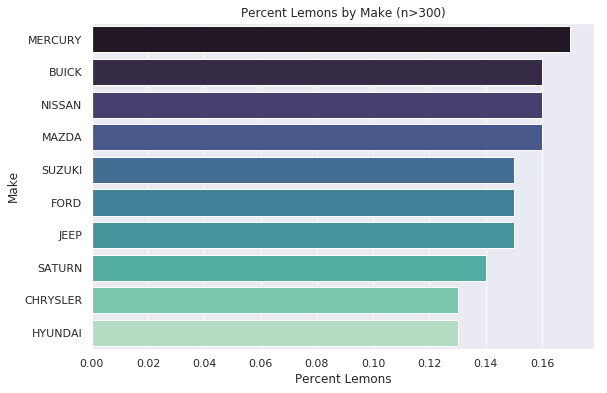

In [29]:
sns.set(palette='mako_r')
plt.figure(figsize=(9,6))

sns.barplot(y=all_makes[all_makes.vic_cnt>321].sort_values(by='lem_pct',ascending=False)['Make'][:10],
            x=all_makes[all_makes.vic_cnt>321].sort_values(by='lem_pct',ascending=False)['lem_pct'][:10],
            palette='mako')
plt.title('Percent Lemons by Make (n>300)')
plt.ylabel('Make')
plt.xlabel('Percent Lemons')
plt.savefig('lemonsbymake.png')

In [30]:
corrs = pd.concat([char_dummies,disp_keys],1)

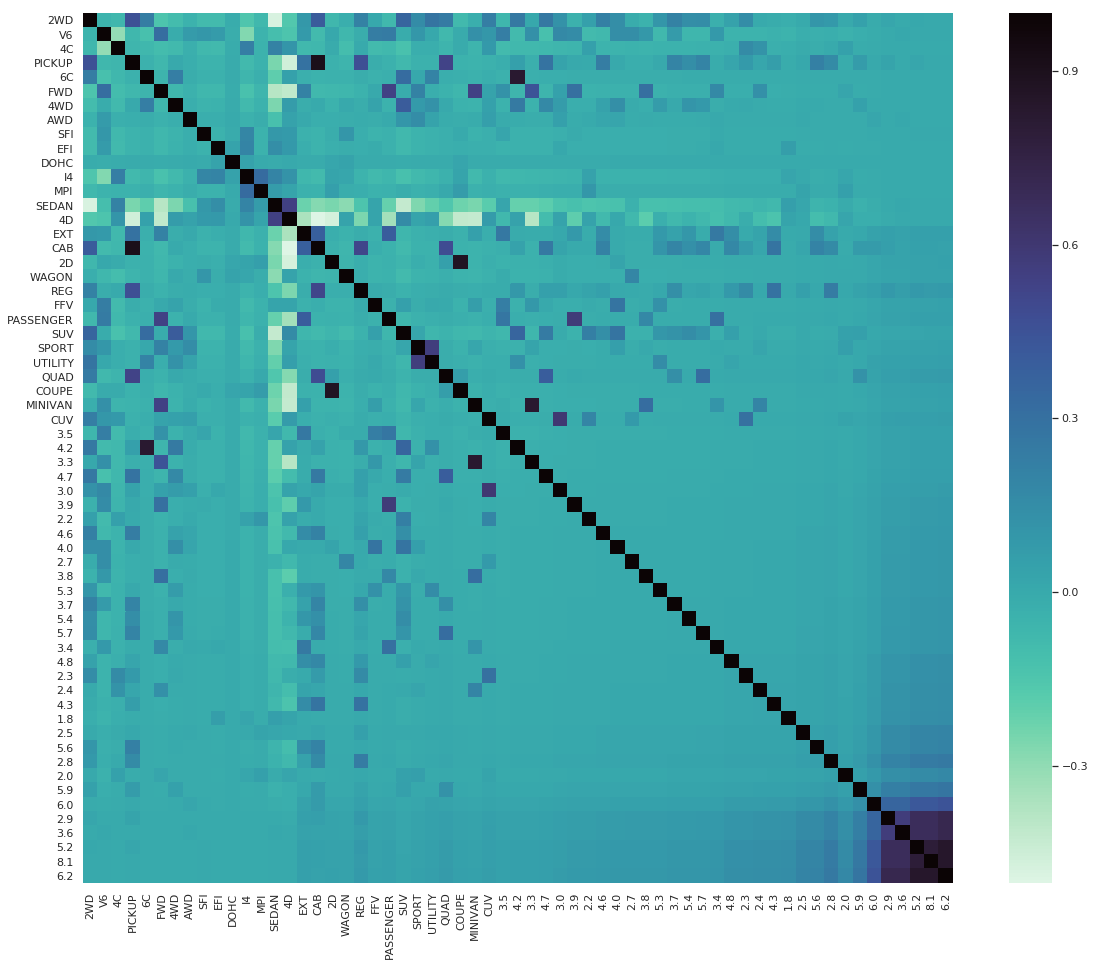

In [31]:
corrmat = corrs.corr()
with sns.axes_style('white'):    
    ax = plt.subplots(figsize=(20,16))

    sns.heatmap(corrmat,
            vmax=1, 
            cmap="mako_r",            
            
            square=True)
           


plt.savefig('carcorrheatlemon.png')

In [32]:
print(corrmat.shape)
c = corrmat.unstack().reset_index()
#take a look at the distribution of the higher correlated pairs.
c = c.loc[(c[0]!=1)&(c[0]>.75)]
c.sort_values(by=0,ascending=False)

(61, 61)


,level_0,level_1,0
199,PICKUP,CAB,0.911014
979,CAB,PICKUP,0.911014
1063,2D,COUPE,0.874932
1603,COUPE,2D,0.874932
3659,8.1,6.2,0.843254
3719,6.2,8.1,0.843254
3598,5.2,6.2,0.843254
3718,6.2,5.2,0.843254
274,6C,4.2,0.828402
1834,4.2,6C,0.828402


In [33]:
states1 = df.VNST.value_counts().reset_index().sort_values(by='VNST',ascending=False)
states2 = states1[:10]

In [34]:
labels = states2['index']
values = states2.VNST
colors = colors

trace = go.Pie(labels=labels, values=values,
               hoverinfo='label+percent', textinfo='value', 
               textfont=dict(size=14),
               marker=dict(colors=colors, 
                           line=dict(color='#000000', width=2)))

py.iplot([trace], filename='piestates.png')

In [35]:
nation = df.Nationality.value_counts().reset_index().sort_values(by='Nationality')

In [36]:
x = list(nation.Nationality)
y = list(nation['index'])

trace2 = go.Bar(
    x=x,
    y=y,
    orientation = 'h',
    marker = dict(
    color = colors[5:]
        
    )
)


data = [trace2]

fig = go.Figure(data=data)
py.iplot(fig, filename='nation1')

In [37]:
x = df.VehBCost

trace1 = go.Histogram(
    x=x,
    
    name='Cost',
    
    marker=dict(
        color=colors[7],
    ),
    opacity=0.75
)
layout = go.Layout(
    title='Acquisition Price',
    xaxis=dict(
        title='Cost'
    ),
    yaxis=dict(
        title='Count'
    ),
    bargap=0.2,
    bargroupgap=0.1
)
data = [trace1]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='pricepaid1')

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/plotly/plotly/plotly.py:233: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.



In [ ]:
"""# Create and style traces
trace0 = go.Scatter(
    x = df.VehYear,
    y = df.MMRAcquisitionAuctionAveragePrice,
    name = 'MMRAcquisitionAuctionAveragePrice',
    line = dict(
        color = colors[7],
        width = 2,
        dash = 'dot')
)
trace1 = go.Scatter(
    x = df.VehYear,
    y = df.MMRAcquisitionAuctionCleanPrice,
    name = 'MMRAcquisitionAuctionCleanPrice',
    line = dict(
        color = colors[8],
        width = 2,
        dash = 'dot')
)
trace2 = go.Scatter(
    x = df.VehYear,
    y = df.MMRAcquisitionRetailAveragePrice,
    name = 'MMRAcquisitionRetailAveragePrice',
    line = dict(
        color = colors[9],
        width = 3)
         # dash options include 'dash', 'dot', and 'dashdot'
)
trace3 = go.Scatter(
    x = df.VehYear,
    y = df.MMRAcquisitonRetailCleanPrice,
    name = 'MMRAcquisitonRetailCleanPrice',
    line = dict(
        color = colors[6],
        width = 3)
)
trace4 = go.Scatter(
    x = df.VehYear,
    y = df.MMRCurrentAuctionAveragePrice,
    name = 'MMRCurrentAuctionAveragePrice',
    line = dict(
        color = colors[3],
        width = 2,
        dash = 'dot')
)
trace5 = go.Scatter(
    x = df.VehYear,
    y = df.MMRCurrentAuctionCleanPrice,
    name = 'MMRCurrentAuctionCleanPrice',
    line = dict(
        color = colors[4],
        width = 2,
        dash = 'dot')
)
trace6 = go.Scatter(
    x = df.VehYear,
    y = df.MMRCurrentRetailAveragePrice,
    name = 'MMRCurrentRetailAveragePrice',
    line = dict(
        color = colors[2],
        width = 3)
)
trace7 = go.Scatter(
    x = df.VehYear,
    y = df.MMRCurrentRetailCleanPrice,
    name = 'MMRCurrentRetailCleanPrice',
    line = dict(
        color = colors[1],
        width = 3)
)
trace8 = go.Scatter(
    x = df.VehYear,
    y = df.VehBCost,
    name = 'Vehicle Cost',
    line = dict(
        color = colors[0],
        width = 4)
)
data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7, trace8]

# Edit the layout
layout = dict(title = 'Average Vehicle Valuation by Year and Category',
              xaxis = dict(title = 'Vehicle Year'),
              yaxis = dict(title = 'Price (USD)'),
              )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='stylesd')"""
#check on plotly

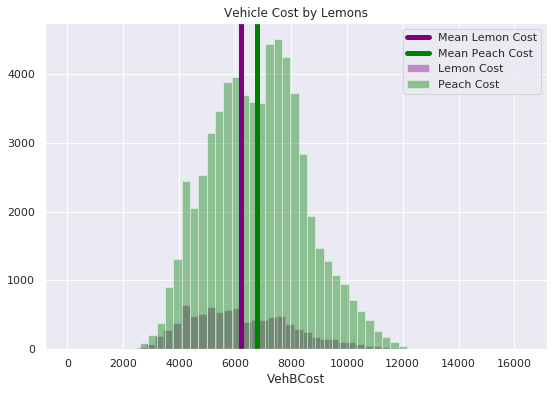

In [38]:
class1 = class1.loc[class1.VehBCost < 16000]

sns.set_context('talk')
sns.set(style='darkgrid',palette='mako')
plt.figure(figsize=(9,6))
sns.distplot(class1.VehBCost.dropna(),color='purple',label='Lemon Cost',kde=False)
sns.distplot(class0.VehBCost.dropna(),color='g',label='Peach Cost',kde=False)
plt.axvline(class1.VehBCost.mean(),c='purple',label='Mean Lemon Cost',linewidth=5)
plt.axvline(class0.VehBCost.mean(),c='g',label='Mean Peach Cost',linewidth=5)
plt.legend(loc='upper right')

plt.title('Vehicle Cost by Lemons')
plt.show()

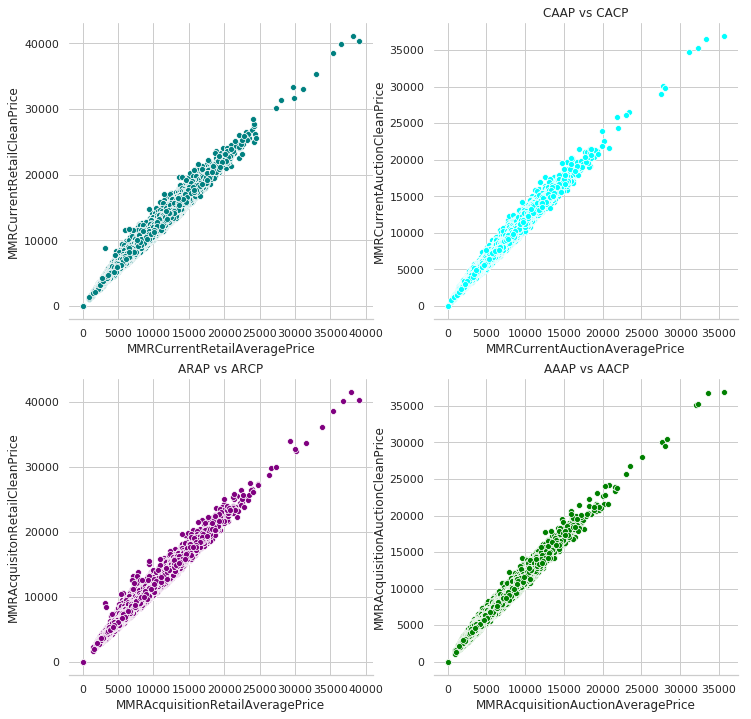

In [39]:
sns.set(style="whitegrid")
f, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=False)
sns.despine(left=True)
sns.scatterplot(x='MMRCurrentRetailAveragePrice',y='MMRCurrentRetailCleanPrice',color='teal',data=plodf, ax=axes[0, 0]).set_title('CRAP vs CRCP',color='white')
sns.scatterplot(x='MMRCurrentAuctionAveragePrice',y='MMRCurrentAuctionCleanPrice',color='aqua',data=plodf,ax=axes[0, 1]).set_title("CAAP vs CACP")
sns.scatterplot(x='MMRAcquisitionRetailAveragePrice',y='MMRAcquisitonRetailCleanPrice',color='purple',data=plodf,ax=axes[1, 0]).set_title('ARAP vs ARCP')
sns.scatterplot(x='MMRAcquisitionAuctionAveragePrice',y='MMRAcquisitionAuctionCleanPrice',color='green',data=plodf, ax=axes[1, 1]).set_title('AAAP vs AACP')
plt.savefig('subplotco1sts.png')